In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.stats import sigma_clip
from astropy.table import Table, Column, vstack

import numpy as np 
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import NonUniformImage

from astroML.stats import binned_statistic_2d

from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

plt.rc('text', usetex=True)

## Figure that shows key model predictions

In [2]:
test_dir = '../model/'
model_str = 'final_6'

# The configuration file
config_file = os.path.join(test_dir, 'asap_test_%s.yaml' % model_str)

# The results of the final sampling process
result_file = os.path.join(test_dir, 'asap_test_%s_sample.npz' % model_str)

# Initialize the model, load the data
cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Load in the final sampling results
(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

_, n_step, n_dim = mod_result_chains.shape

mod_result_best = np.nanmean(mod_result_chains[:, -int(n_step * 0.1):, :].reshape([-1, n_dim]), axis=0)

# Predict the stellar mass in inner and outer apertures
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=10.5,
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

# Predict the SMFs and DeltaSigma profiles
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(
    mod_result_best, cfg, obs_data, um_data)

# Check the likelihood for SMF and DeltaSigma profiles
lnlike_smf, lnlike_dsigma = ln_likelihood(
    mod_result_best, cfg, obs_data, um_data, sep_return=True)

# The useful part of the mock catalog
um_mock_use = um_data['um_mock'][mask_use]

print("\n# Best parameters: ", mod_result_best)
print("# ln(Likelihood) for SMFs   : %8.4f" % lnlike_smf)
print("# ln(Likelihood) for DSigma : %8.4f" % lnlike_dsigma)

print("\n", mod_result_best)

# Running model: asap_test_final_6
#    Will use emcee as sampler ...
#    Use   256 walkers with    snooker moves for   200 x  3 steps of burn-in
#    Use   256 walkers with        kde moves for  9000 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_short.npy
# DSigma results : um_smdpl_insitu_exsitu_0.7124_basic_logmp_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total 

### Figure that shows the aperture mass plane and the definitions of the mass bins

In [3]:
from palettable.colorbrewer.sequential import Reds_8, Blues_8
from matplotlib.colors import ListedColormap

obs_cmap = ListedColormap(Reds_8.mpl_colors[2:])
mod_cmap = ListedColormap(Blues_8.mpl_colors[2:])

In [4]:
def hist_to_density(X, Y, H, levels=None):
    """
    Convert 2-D histograms into density.
    """
    if levels is None:
        levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)
        
    # Compute the density levels.
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
    V.sort()
    
    m = np.diff(V) == 0
    if np.any(m) and not quiet:
        logging.warning("Too few points to create valid contours")
    while np.any(m):
        V[np.where(m)[0][0]] *= 1.0 - 1e-4
        m = np.diff(V) == 0
    V.sort()

    # Compute the bin centers.
    X1, Y1 = 0.5 * (X[1:] + X[:-1]), 0.5 * (Y[1:] + Y[:-1])

    # Extend the array for the sake of the contours at the plot edges.
    H2 = H.min() + np.zeros((H.shape[0] + 4, H.shape[1] + 4))
    H2[2:-2, 2:-2] = H
    H2[2:-2, 1] = H[:, 0]
    H2[2:-2, -2] = H[:, -1]
    H2[1, 2:-2] = H[0]
    H2[-2, 2:-2] = H[-1]
    H2[1, 1] = H[0, 0]
    H2[1, -2] = H[0, -1]
    H2[-2, 1] = H[-1, 0]
    H2[-2, -2] = H[-1, -1]
    
    X2 = np.concatenate([
        X1[0] + np.array([-2, -1]) * np.diff(X1[:2]),
        X1,
        X1[-1] + np.array([1, 2]) * np.diff(X1[-2:]),
    ])
    
    Y2 = np.concatenate([
        Y1[0] + np.array([-2, -1]) * np.diff(Y1[:2]),
        Y1,
        Y1[-1] + np.array([1, 2]) * np.diff(Y1[-2:]),
    ])
    
    return X2, Y2, H2, V

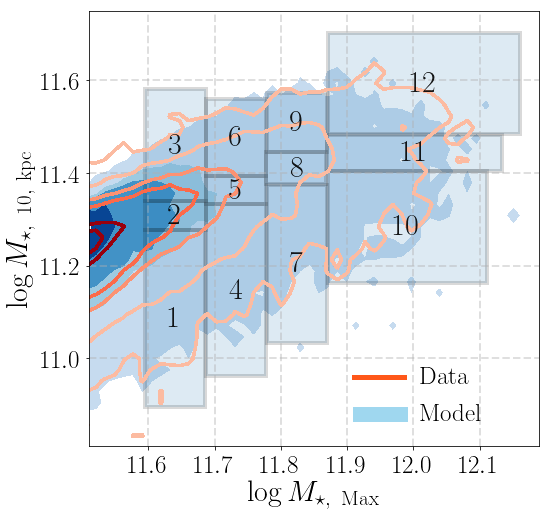

In [118]:
fig_1 = plt.figure(figsize=(7.5, 7))
fig_1.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)
ax1 = fig_1.add_subplot(111)

ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
_ = ax1.set_xlim(11.51, 12.19)
_ = ax1.set_ylim(10.81, 11.75)

# Mmax - M10 scatter plot
mask_mod = ((logms_tot >= 11.49) & (logms_tot <= 12.20) & 
            (logms_inn >= 10.75) & (logms_inn <= 11.70))

# Contour levels
levels = [0.05, 0.16, 0.50, 0.67, 0.90, 0.99]

# ------ Model ------ #
# Density plot for the model predictions
mod_count, xbins, ybins = np.histogram2d(
    x_arr, y_arr, density=False, range=[[11.50, 12.20], [10.75, 11.70]], bins=[50, 40])

# Smooth 
mod_count = gaussian_filter(mod_count, 0.5)

x_new, y_new, mod_den, mod_levels = hist_to_density(xbins, ybins, mod_count, levels=levels)

ax1.contourf(x_new, y_new, mod_den.T, levels=mod_levels, linewidths=3, 
             antialiased=False, cmap=mod_cmap)

#HM = ax1.imshow(np.log10(mod_count.T), origin='lower',
#                extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
#                aspect='auto', interpolation='nearest',
#                cmap='OrRd', label=r'$\mathrm{Model}$')

# ------ Data ------ #
obs_count, xbins, ybins = np.histogram2d(
    obs_data['mtot'], obs_data['minn'], density=False, range=[[11.50, 12.20], [10.75, 11.70]], bins=[50, 40])

# Smooth 
obs_count = gaussian_filter(obs_count, 0.7)

x_new, y_new, obs_den, obs_levels = hist_to_density(xbins, ybins, obs_count, levels=levels)

ax1.contour(x_new, y_new, obs_den.T, levels=obs_levels, linewidths=2.5, 
            antialiased=False, cmap=obs_cmap)

# Create a manual legend
ax1.plot([11.91, 11.985], [10.96, 10.96], linewidth=5, color='orangered', alpha=0.9)
ax1.text(12.01, 10.96, r'$\mathrm{Data}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

ax1.plot([11.92, 11.98], [10.88, 10.88], linewidth=15, color='skyblue', alpha=0.8)
ax1.text(12.01, 10.88, r'$\mathrm{Model}$', fontsize=25, 
         horizontalalignment='left', verticalalignment='center')

_ = ax1.set_xlabel(r'$\log M_{\star,\ \mathrm{Max}}$', fontsize=30)
_ = ax1.set_ylabel(r'$\log M_{\star,\ \mathrm{10,\ kpc}}$', fontsize=30)


for ii in np.arange(12):
    obs_prof = obs_data['wl_dsigma'][ii]
    ax1.add_patch(
        patches.Rectangle(
            (obs_prof['min_logm1'], obs_prof['min_logm2']),
            (obs_prof['max_logm1'] - obs_prof['min_logm1']),
            (obs_prof['max_logm2'] - obs_prof['min_logm2']), 
            alpha=0.15, edgecolor='k', linewidth=4))
    ax1.text((obs_prof['max_logm1'] + obs_prof['min_logm1']) / 2.0, 
             (obs_prof['max_logm2'] + obs_prof['min_logm2']) / 2.0,
             r"$%d$" % (ii + 1), 
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=30, color='k', alpha=0.9)

### Figure to compare the SMFs

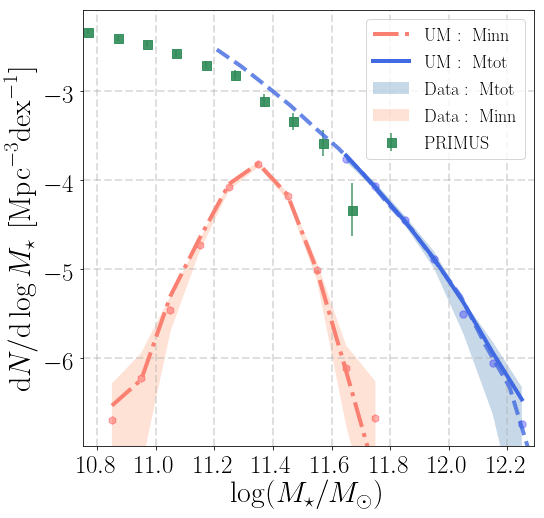

In [119]:
fig_2 = plt.figure(figsize=(7.5, 7))
fig_2.subplots_adjust(left=0.16, right=0.995, bottom=0.13, top=0.995, wspace=0.00, hspace=0.00)

ax1 = fig_2.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.4, zorder=0)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

# These are the SMFs and stellar mass data
obs_smf_tot = obs_data['smf_tot']
obs_smf_inn = obs_data['smf_inn']
obs_logms_tot = obs_data['mtot']
obs_logms_inn = obs_data['minn']
obs_smf_full = obs_data['smf_full']

# This is the model SMF with broader mass range
um_smf_tot_all = smf.get_smf_bootstrap(logms_tot, cfg['um']['volume'], 18, 11.0, 12.5, n_boots=1)

# Show the PRIMUS SMF
ax1.errorbar(obs_smf_full['logm_mean'][6:] + 0.17,
             np.log10(obs_smf_full['smf'][6:]),
             (np.log10(obs_smf_full['smf_upp'][6:]) - np.log10(obs_smf_full['smf'][6:])),
             fmt='o', color='seagreen', ecolor='seagreen', alpha=0.9, marker='s', markersize=9,
             label=r'$\mathrm{PRIMUS}$', zorder=0)

# Show the HSC SMFs
ax1.fill_between(obs_smf_tot['logm_mean'], np.log10(obs_smf_tot['smf_low']), np.log10(obs_smf_tot['smf_upp']),
                 facecolor='steelblue', edgecolor='none', interpolate=True, alpha=0.3,
                 label=r'$\mathrm{Data:\ Mtot}$')

ax1.fill_between(obs_smf_inn['logm_mean'], np.log10(obs_smf_inn['smf_low']), np.log10(obs_smf_inn['smf_upp']),
                 facecolor='lightsalmon', edgecolor='none', interpolate=True, alpha=0.3,
                 label=r'$\mathrm{Data:\ Minn}$')

ax1.scatter(obs_smf_inn['logm_mean'], np.log10(obs_smf_inn['smf']),
            marker='h', c='r', s=60, label='__no_label__', alpha=0.3)

ax1.scatter(obs_smf_tot['logm_mean'], np.log10(obs_smf_tot['smf']),
            marker='8', c='b', s=60, label='__no_label__', alpha=0.3)


# Predicted SMF
ax1.plot(obs_smf_inn['logm_mean'], np.log10(um_smf_inn),
         linewidth=4, linestyle='-.', c='salmon', alpha=1.0, label=r'$\mathrm{UM:\ Minn}$')

ax1.plot(um_smf_tot_all['logm_mean'][2:], np.log10(um_smf_tot_all['smf'][2:]),
         linewidth=4, linestyle='--', c='royalblue', alpha=0.8, label='__no_label__')

ax1.plot(obs_smf_tot['logm_mean'], np.log10(um_smf_tot),
         linewidth=4, linestyle='-', c='royalblue', alpha=1.0, label=r'$\mathrm{UM:\ Mtot}$')


ax1.legend(fontsize=18, loc='upper right')

ax1.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=30)
ax1.set_ylabel((r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ $'
                r'$[{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$'), size=30)

_ = ax1.set_xlim(10.75, 12.29)
_ = ax1.set_ylim(-6.99, -2.09)

### Figure that shows the predicted DeltaSigma profiles 

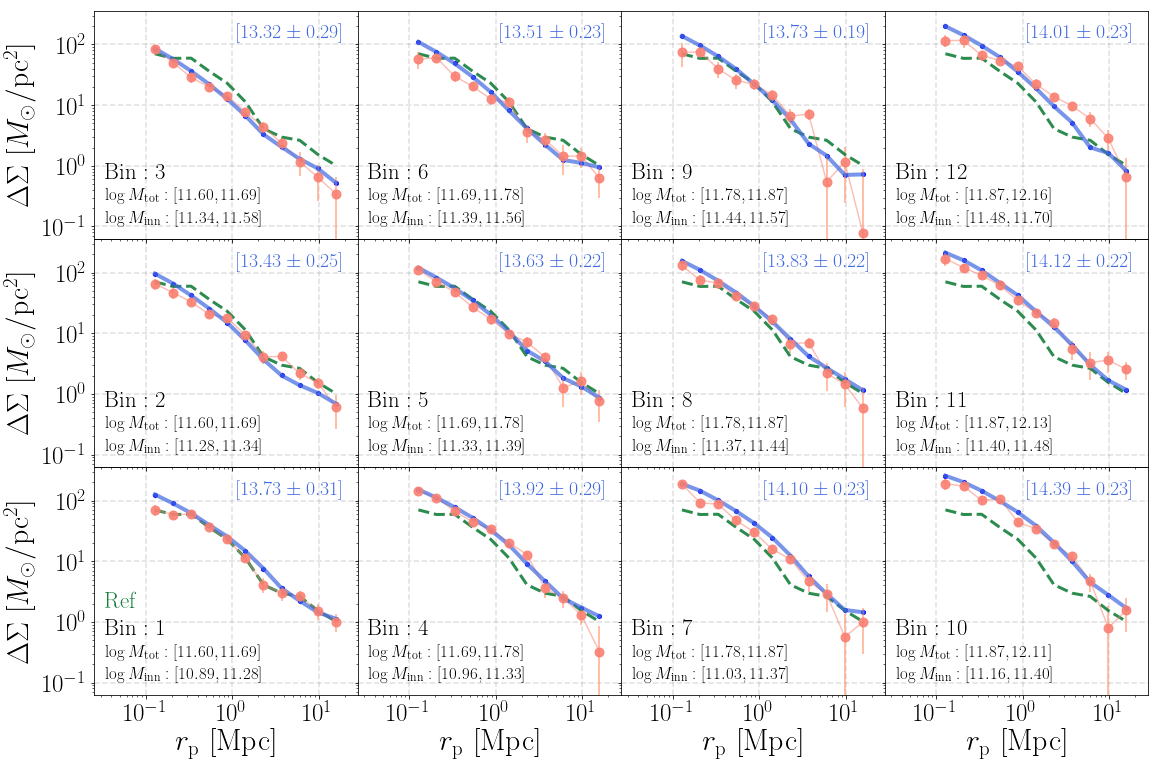

In [120]:
um_mhalo_tuple = predict_mhalo(
    obs_data['wl_dsigma'], um_data['um_mock'][mask_use], logms_tot, logms_inn)

mod_dsig = plotting.plot_dsigma_profiles(
    obs_data['wl_dsigma'], um_dsigma, um_mhalo=um_mhalo_tuple, reference=0)

### Save the figures

In [121]:
fig_1.savefig('fig/fig4_a_plane.pdf', dpi=120)

fig_2.savefig('fig/fig4_b_smsf.pdf', dpi=120)

mod_dsig.savefig('fig/fig4_c_dsigma.pdf', dpi=120)

#### Making a slightly different figure for proposal

In [22]:
def plot_dsigma_profiles(obs_wl_dsigma, um_wl_profs, um_mhalo=None,
                         each_col=3, reference=None):
    """Plot the UM predicted weak lensing profiles."""
    obs_wl_n_bin = len(obs_wl_dsigma)
    if obs_wl_n_bin <= each_col:
        n_row = obs_wl_n_bin
        n_col = 1
    else:
        n_row = each_col
        n_col = int(np.ceil(obs_wl_n_bin / each_col))

    fig = plt.figure(figsize=(3.5 * n_col, 3.5 * n_row))
    fig.subplots_adjust(left=0.08, right=0.995, bottom=0.09, top=0.995,
                        wspace=0.00, hspace=0.00)

    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(wspace=0.0, hspace=0.00)

    y_min_arr = np.array([np.nanmin(prof['dsigma']) for prof in obs_wl_dsigma])
    y_min_arr = np.where(y_min_arr <= 0.0, np.nan, y_min_arr)
    y_max_arr = np.array([np.nanmax(prof['dsigma']) for prof in obs_wl_dsigma])
    y_min = np.nanmin(y_min_arr) * 0.8
    y_max = np.nanmax(y_max_arr) * 1.9

    if reference is not None:
        ref_prof = obs_wl_dsigma[reference]
    else:
        ref_prof = None

    for ii in range(obs_wl_n_bin):
        col_id = int(np.floor(ii / n_row))
        row_id = int(n_row - (ii + 1 - col_id * n_row))

        ax = plt.subplot(gs[row_id, col_id])
        ax.loglog()

        ax.grid(linestyle='--', linewidth=1.5, alpha=0.4, zorder=0)

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(25)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(25)

        if ref_prof is not None:
            ax.plot(ref_prof['r_mpc'], ref_prof['dsigma'], linewidth=3.0,
                    color=GRN(0.8), linestyle='--', alpha=0.9)

        # Observed WL profile
        obs_prof = obs_wl_dsigma[ii]
        ax.errorbar(
            obs_prof['r_mpc'], obs_prof['dsigma'], obs_prof['dsigma_err'],
            fmt='o', color='salmon', ecolor='lightsalmon', markersize=7, alpha=0.9)
        ax.plot(
            obs_prof['r_mpc'], obs_prof['dsigma'], linewidth=1.5, color='salmon', alpha=0.5)

        if reference is not None and reference == ii:
            ax.text(0.04, 0.41, r'$\mathrm{Ref}$',
                    verticalalignment='center', horizontalalignment='left',
                    fontsize=23.0, transform=ax.transAxes, color=GRN(0.8),
                    alpha=1.0)

        # Label the mass range
        ax.text(0.04, 0.29, r'${\rm Bin: %d}$' % (ii + 1),
                verticalalignment='center', horizontalalignment='left',
                fontsize=23.0, transform=ax.transAxes, color='k', alpha=1.0)

        ax.text(
            0.04, 0.18,
            r"$\log M_{\rm tot}:[%5.2f,%5.2f]$" % (
                obs_prof['min_logm1'], obs_prof['max_logm1']),
            verticalalignment='center', horizontalalignment='left',
            fontsize=17.0, transform=ax.transAxes, color='k', alpha=1.0)

        ax.text(
            0.04, 0.08, r"$\log M_{\rm inn}:[%5.2f,%5.2f]$" % (
                obs_prof['min_logm2'], obs_prof['max_logm2']),
            verticalalignment='center', horizontalalignment='left',
            fontsize=17.0, transform=ax.transAxes, color='k', alpha=1.0)

        # Predicted WL profile
        if isinstance(um_wl_profs[0], (list,)):
            for dsig in um_wl_profs:
                ax.plot(obs_prof['r_mpc'], dsig[ii],
                        linewidth=2.5, color='royalblue', alpha=0.7)
        else:
            ax.scatter(obs_prof['r_mpc'], um_wl_profs[ii], marker='h',
                       s=15, c='b', alpha=0.9)
            ax.plot(obs_prof['r_mpc'], um_wl_profs[ii],
                    linewidth=4.0, color='royalblue', alpha=0.7)

        if um_mhalo is not None:
            ax.text(0.49, 0.90, r"$[%5.2f \pm %5.2f]$" % um_mhalo[ii],
                    verticalalignment='center', horizontalalignment='left',
                    fontsize=20.0, transform=ax.transAxes, color='royalblue')

        # X, Y Limits
        x_min = np.min(obs_prof['r_mpc']) * 0.2
        x_max = np.max(obs_prof['r_mpc']) * 1.8
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        if col_id != 0:
            ax.yaxis.set_major_formatter(NullFormatter())
        else:
            ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', fontsize=30)
        if row_id == (n_row - 1):
            ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', fontsize=30)
        else:
            ax.xaxis.set_major_formatter(NullFormatter())

    return fig

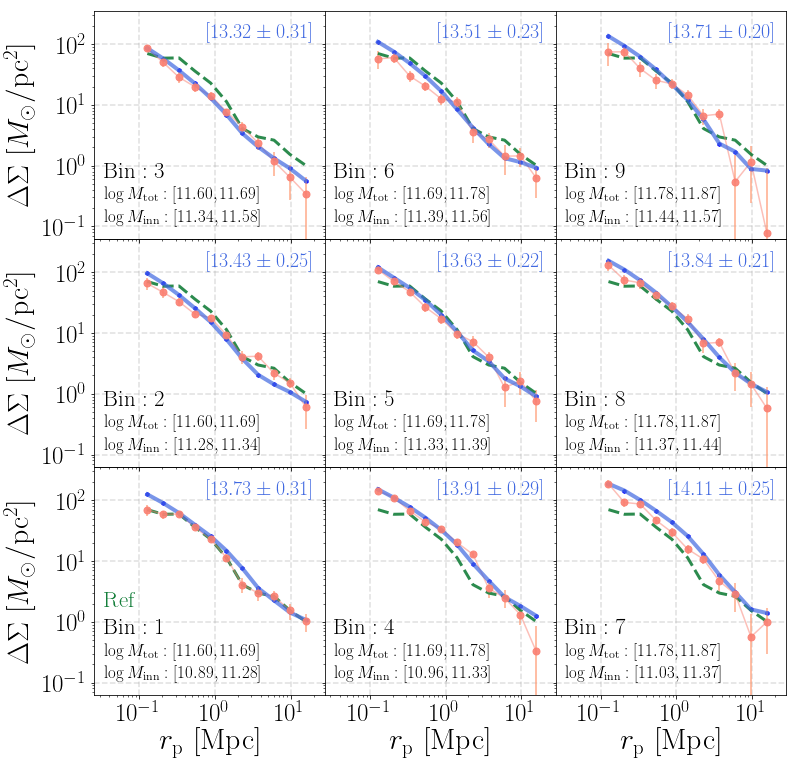

In [23]:
from matplotlib import gridspec
from matplotlib.ticker import NullFormatter

ORG = plt.get_cmap('OrRd')
ORG_2 = plt.get_cmap('YlOrRd')
BLU = plt.get_cmap('PuBu')
BLK = plt.get_cmap('Greys')
PUR = plt.get_cmap('Purples')
GRN = plt.get_cmap('Greens')

um_mhalo_tuple = predict_mhalo(
    obs_data['wl_dsigma'], um_data['um_mock'][mask_use], logms_tot, logms_inn)

mod_dsig = plot_dsigma_profiles(
    obs_data['wl_dsigma'][:9], um_dsigma[:9], um_mhalo=um_mhalo_tuple, 
    reference=0)